<h1>Модуль A</h1>

<h3>0. Импорт бибилиотек</h3>

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3

<h3>1.1 Загрузка данных</h3>

In [13]:
expenses = pd.read_csv('expenses.csv')
expenses

,dt,Channel,costs
0,2022-05-01,FaceBoom,113.3
1,2022-05-02,FaceBoom,78.1
2,2022-05-03,FaceBoom,85.8
3,2022-05-04,FaceBoom,136.4
4,2022-05-05,FaceBoom,122.1
...,...,...,...
1795,2022-10-23,lambdaMediaAds,4.0
1796,2022-10-24,lambdaMediaAds,6.4
1797,2022-10-25,lambdaMediaAds,8.8
1798,2022-10-26,lambdaMediaAds,8.8


In [16]:
orders = pd.read_csv('orders.csv')
orders

,User Id,Event Dt,Revenue
0,188246423999,2022-05-01 23:09:52,4.99
1,174361394180,2022-05-01 12:24:04,4.99
2,529610067795,2022-05-01 11:34:04,4.99
3,319939546352,2022-05-01 15:34:40,4.99
4,366000285810,2022-05-01 13:59:51,4.99
...,...,...,...
40207,651604369137,2022-10-31 16:19:07,4.99
40208,275341387049,2022-10-31 01:17:17,4.99
40209,374656616484,2022-10-31 06:17:29,4.99
40210,168548862926,2022-10-31 22:46:19,4.99


In [17]:
visitation = pd.read_csv('visitation.csv')
visitation

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,Russia,iPhone,organic,2022-05-01 02:36:01,2022-05-01 02:45:01
1,278965908054,Russia,iPhone,organic,2022-05-01 04:46:31,2022-05-01 04:47:35
2,590706206550,Russia,Mac,organic,2022-05-01 14:09:25,2022-05-01 15:32:08
3,326433527971,Russia,Android,TipTop,2022-05-01 00:29:59,2022-05-01 00:54:25
4,349773784594,Russia,Mac,organic,2022-05-01 03:33:35,2022-05-01 03:57:40
...,...,...,...,...,...,...
309896,329994900775,Turkey,PC,LeapBob,2022-10-31 13:28:12,2022-10-31 14:39:29
309897,334903592310,Thailand,PC,lambdaMediaAds,2022-10-31 22:14:52,2022-10-31 22:39:36
309898,540102010126,China,PC,organic,2022-10-31 01:40:48,2022-10-31 01:41:31
309899,308736936846,China,Mac,organic,2022-10-31 07:37:34,2022-10-31 07:37:55


Здесь были загруженны все предоставленные наборы данных для последующего добавления их в базу данных

<h4>Создание базы данных</h4>

In [34]:
try:
    con = sqlite3.connect('Users.db')
    cursor = con.cursor()

    cursor.execute('''CREATE TABLE IF NOT EXISTS expenses (
                dt TEXT,
                Channel TEXT,
                costs REAL
                )
            ''')
    cursor.execute('''CREATE TABLE IF NOT EXISTS orders(
                User_Id INTEGER PRIMARY KEY,
                Event_Dt TEXT,
                Revenue REAL 
                )
            ''')
    cursor.execute('''CREATE TABLE IF NOT EXISTS visitation(
                User_Id	INTEGER PRIMARY KEY,
                Region TEXT,
                Device TEXT,
                Channel	TEXT,
                Session_Start TEXT,
                Session_End TEXT
                )
            ''')

    expenses.to_sql('expenses', con, if_exists='replace')
    orders.to_sql('orders', con, if_exists='replace')
    visitation.to_sql('visitation', con, if_exists='replace')

except sqlite3.Error as e:
    print(f'Error {e}')

except Exception as e:
    print(f'Error {e}')
    
finally:
    if con:
        con.close()

Здесь создается база данных, где находятся все 3 имеющихся набора данных, а также были предусмотренны ошибки при работе с базой данных и общие ошибки, которые могут возникнуть.

<h4>Извлечение данных из базы данных</h4>

In [ ]:
try:
    con = sqlite3.connect('Users.db')
    cursor = con.cursor()

    expenses = pd.read_sql_query('SELECT * FROM expenses', con)
    orders = pd.read_sql_query('SELECT * FROM orders', con)
    visitation = pd.read_sql_query('SELECT * FROM visitation', con)
    visitation
    
except sqlite3.Error as e:
    print(f'Error {e}')

except Exception as e:
    print(f'Error {e}')
    
finally:
    if con:
        con.close()

,index,User Id,Region,Device,Channel,Session Start,Session End
0,0,981449118918,Russia,iPhone,organic,2022-05-01 02:36:01,2022-05-01 02:45:01
1,1,278965908054,Russia,iPhone,organic,2022-05-01 04:46:31,2022-05-01 04:47:35
2,2,590706206550,Russia,Mac,organic,2022-05-01 14:09:25,2022-05-01 15:32:08
3,3,326433527971,Russia,Android,TipTop,2022-05-01 00:29:59,2022-05-01 00:54:25
4,4,349773784594,Russia,Mac,organic,2022-05-01 03:33:35,2022-05-01 03:57:40
...,...,...,...,...,...,...,...
309896,309896,329994900775,Turkey,PC,LeapBob,2022-10-31 13:28:12,2022-10-31 14:39:29
309897,309897,334903592310,Thailand,PC,lambdaMediaAds,2022-10-31 22:14:52,2022-10-31 22:39:36
309898,309898,540102010126,China,PC,organic,2022-10-31 01:40:48,2022-10-31 01:41:31
309899,309899,308736936846,China,Mac,organic,2022-10-31 07:37:34,2022-10-31 07:37:55


Здесь извлекаются все наборы данных в формате DataFrame, которые были загружены в базу данных и точно также предусматриваются ошибки при чтении данных и общие ошибки.

<h3>1.2 Предварительная обработка данных</h3>

In [43]:
expenses.drop(columns='index', inplace=True)
expenses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [44]:
expenses.duplicated().sum()

0

In [48]:
expenses['dt'] = pd.to_datetime(expenses['dt'], format='%Y-%m-%d')
expenses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   dt       1800 non-null   datetime64[ns]
 1   Channel  1800 non-null   object        
 2   costs    1800 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 42.3+ KB


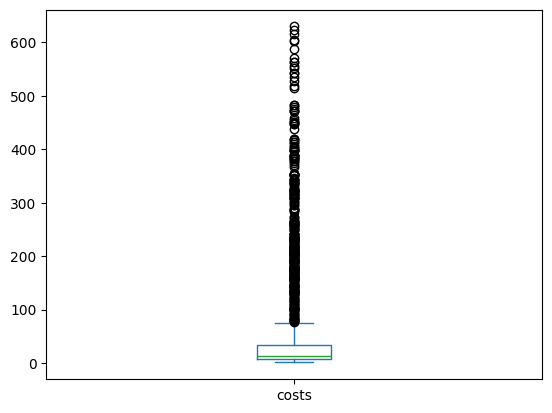

In [49]:
expenses['costs'].plot(kind='box')
plt.show()

In [58]:

channels_cost = expenses.groupby('Channel')['costs'].mean()
channels_cost

Channel
AdNonSense             21.729167
FaceBoom              180.253333
LeapBob                 9.986667
MediaTornado            5.302667
OppleCreativeMedia     11.951389
RocketSuperAds         10.183333
TipTop                304.173889
WahooNetBanner         28.616667
YRabbit                 5.245667
lambdaMediaAds          8.653333
Name: costs, dtype: float64

In [59]:
orders.drop(columns='index', inplace=True)
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [61]:
orders['Event Dt'] = pd.to_datetime(orders['Event Dt'], format='%Y-%m-%d %H:%M:%S')
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   User Id   40212 non-null  int64         
 1   Event Dt  40212 non-null  datetime64[ns]
 2   Revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


In [72]:
orders['Revenue'].unique()


array([ 4.99,  5.99,  9.99, 49.99, 19.99])

In [77]:
orders[orders['Revenue'] == 9.99]

,User Id,Event Dt,Revenue
168,204226234942,2022-05-06 15:26:40,9.99
242,162122420677,2022-05-08 18:05:59,9.99
248,204634485980,2022-05-08 00:45:53,9.99
441,510685611257,2022-05-11 00:25:51,9.99
500,59649027450,2022-05-12 18:48:52,9.99
...,...,...,...
39634,714957010899,2022-10-25 04:46:35,9.99
39745,740442294667,2022-10-26 19:55:39,9.99
39895,211622511289,2022-10-28 15:30:46,9.99
40035,311736507005,2022-10-29 05:44:30,9.99


In [78]:
visitation.drop(columns='index', inplace=True)
visitation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [79]:
visitation['Session Start'] = pd.to_datetime(visitation['Session Start'], format='%Y-%m-%d %H:%M:%S')
visitation['Session End'] = pd.to_datetime(visitation['Session End'], format='%Y-%m-%d %H:%M:%S')
visitation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   User Id        309901 non-null  int64         
 1   Region         309901 non-null  object        
 2   Device         309901 non-null  object        
 3   Channel        309901 non-null  object        
 4   Session Start  309901 non-null  datetime64[ns]
 5   Session End    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


In [81]:
visitation.duplicated().sum()

0

In [82]:
visitation['Region'].unique()

array(['Russia', 'Turkey', 'Thailand', 'China'], dtype=object)

In [83]:
visitation['Device'].unique()

array(['iPhone', 'Mac', 'Android', 'PC'], dtype=object)

In [84]:
visitation['Channel'].unique()

array(['organic', 'TipTop', 'RocketSuperAds', 'YRabbit', 'FaceBoom',
       'MediaTornado', 'AdNonSense', 'LeapBob', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)